# SIR model
$$\frac{S}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I.$$

-train on [0,60] and predict on [0,60]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [2]:
# Define the neural network model for each ODE
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN, self).__init__()
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_ = torch.tanh(self.layer1(x))
        x_ = torch.tanh(self.layer2(x_))
        x_ = torch.tanh(self.layer3(x_))
        x_ = torch.sigmoid(self.layer4(x_))
        x_ = self.layer5(x_)
        x_ = self.initial_value + (x - self.initial_point_of_the_domain) * x_
        return x_

In [3]:
# Define the ODE functions
def ode_function1(S, I):
    return -beta*I*S
def ode_function2(S, I):
    return beta*I*S - gamma*I
def ode_function3(S, I):
    return gamma*I

In [4]:
# Parameters

initial_S = 990  # Initial number of susceptible individuals
initial_I = 20  # Initial number of infectious individuals
initial_R = 0 # Initial number of recovered individuals
N = initial_S + initial_I + initial_R # Total population size

beta = 0.001  # Rate of infection
gamma = 0.1  # Rate of recovery

In [5]:
# RK4 
# Function defining the SIS model equations
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

t_span = (0, 60)  # Time span for integration
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Initial conditions
y0 = [initial_S, initial_I, initial_R]

# Solve the ODEs
sol = solve_ivp(SIR_model, t_span, y0, args=(beta, gamma), dense_output=True)

y_eval = sol.sol(t_eval)

In [6]:
# Define the loss function for the PINN
def pinn_loss(model1, model2, model3, x_collocation, ode_function, eq = '1'):
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)
    
    u_pred_collocation_1 = model1(x_collocation_tensor)
    u_pred_collocation_2 = model2(x_collocation_tensor)
    u_pred_collocation_3 = model3(x_collocation_tensor)
    
    if eq == '1':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_1, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_1), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_1 - torch.Tensor(y_eval[0]))**2)
    elif eq == '2':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_2, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_2), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_2 - torch.Tensor(y_eval[1]))**2)
    elif eq == '3':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_3, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_3), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_3 - torch.Tensor(y_eval[2]))**2)
    else:
        return 
    
    # residual loss
    residual_loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
    
    total_loss = residual_loss_collocation + data_loss
    return total_loss

In [7]:
# Define the parameters
input_size = 1
hidden_size = 64
output_size = 1

initial_value_1 = initial_S
initial_value_2 = initial_I
initial_value_3 = initial_R

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 60
number_of_time_steps = 1000

# Create instances of the PINN models
model1 = PINN(input_size, hidden_size, output_size, initial_value_1, initial_point_of_the_domain)
model2 = PINN(input_size, hidden_size, output_size, initial_value_2, initial_point_of_the_domain)
model3 = PINN(input_size, hidden_size, output_size, initial_value_3, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

# Define the optimizer for each model
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)

# Training loop for both models
# Early stopping parameters
best_loss = np.inf
patience = 100
epochs_no_improve = 0
num_epochs = 200000
early_stopping_epochs = 300

losses = []

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()

    loss1 = pinn_loss(model1, model2, model3, x_collocation, ode_function1, '1')
    loss2 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '2')
    loss3 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '3')

    total_loss = loss1 + loss2 + loss3
    
    losses.append(total_loss)

    total_loss.backward()

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    
    # Early stopping check
    if epoch >= early_stopping_epochs:
        if total_loss < best_loss:
            best_loss = total_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break
                
                
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')

# Evaluate the trained models
with torch.no_grad():
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred_tensor1 = model1(x_test_tensor)
    u_pred_tensor2 = model2(x_test_tensor)
    u_pred_tensor3 = model3(x_test_tensor)

    u_pred1 = u_pred_tensor1.numpy()
    u_pred2 = u_pred_tensor2.numpy()
    u_pred3 = u_pred_tensor3.numpy()



Epoch 1/200000, Loss: 1655436.7500
Epoch 101/200000, Loss: 1559793.2500
Epoch 201/200000, Loss: 1457566.5000
Epoch 301/200000, Loss: 1391993.5000
Epoch 401/200000, Loss: 1342583.6250
Epoch 501/200000, Loss: 1300476.0000
Epoch 601/200000, Loss: 1262572.1250
Epoch 701/200000, Loss: 1227076.5000
Epoch 801/200000, Loss: 1192885.6250
Epoch 901/200000, Loss: 1159886.0000
Epoch 1001/200000, Loss: 1127255.2500
Epoch 1101/200000, Loss: 1095151.7500
Epoch 1201/200000, Loss: 1064676.0000
Epoch 1301/200000, Loss: 1034796.1250
Epoch 1401/200000, Loss: 1006222.6250
Epoch 1501/200000, Loss: 979671.7500
Epoch 1601/200000, Loss: 954839.5000
Epoch 1701/200000, Loss: 931414.1875
Epoch 1801/200000, Loss: 909212.3125
Epoch 1901/200000, Loss: 888112.0000
Epoch 2001/200000, Loss: 868021.3125
Epoch 2101/200000, Loss: 848856.5000
Epoch 2201/200000, Loss: 830450.3750
Epoch 2301/200000, Loss: 811774.7500
Epoch 2401/200000, Loss: 793308.2500
Epoch 2501/200000, Loss: 776296.8750
Epoch 2601/200000, Loss: 759957.937

Epoch 21901/200000, Loss: 287929.2500
Epoch 22001/200000, Loss: 287201.6250
Epoch 22101/200000, Loss: 286485.0625
Epoch 22201/200000, Loss: 285775.5625
Epoch 22301/200000, Loss: 285080.7500
Epoch 22401/200000, Loss: 284384.3750
Epoch 22501/200000, Loss: 283693.6562
Epoch 22601/200000, Loss: 283000.0625
Epoch 22701/200000, Loss: 282326.8750
Epoch 22801/200000, Loss: 281660.4062
Epoch 22901/200000, Loss: 281234.0312
Epoch 23001/200000, Loss: 280361.5000
Epoch 23101/200000, Loss: 279756.6250
Epoch 23201/200000, Loss: 279129.5312
Epoch 23301/200000, Loss: 278479.2812
Epoch 23401/200000, Loss: 277868.1875
Epoch 23501/200000, Loss: 277267.0625
Epoch 23601/200000, Loss: 276672.4375
Epoch 23701/200000, Loss: 276081.8125
Epoch 23801/200000, Loss: 275502.4375
Epoch 23901/200000, Loss: 274928.0625
Epoch 24001/200000, Loss: 274362.6250
Epoch 24101/200000, Loss: 273803.1250
Epoch 24201/200000, Loss: 273255.6250
Epoch 24301/200000, Loss: 272705.6562
Epoch 24401/200000, Loss: 272400.2500
Epoch 24501/

Epoch 43501/200000, Loss: 226367.2812
Epoch 43601/200000, Loss: 226286.5469
Epoch 43701/200000, Loss: 226169.9062
Epoch 43801/200000, Loss: 226073.7031
Epoch 43901/200000, Loss: 225975.0312
Epoch 44001/200000, Loss: 225884.2344
Epoch 44101/200000, Loss: 225782.7188
Epoch 44201/200000, Loss: 225688.8438
Epoch 44301/200000, Loss: 225593.0938
Epoch 44401/200000, Loss: 225501.5781
Epoch 44501/200000, Loss: 225406.0000
Epoch 44601/200000, Loss: 225341.3750
Epoch 44701/200000, Loss: 225223.0938
Epoch 44801/200000, Loss: 225146.4375
Epoch 44901/200000, Loss: 225117.7188
Epoch 45001/200000, Loss: 224948.5938
Epoch 45101/200000, Loss: 224859.2500
Epoch 45201/200000, Loss: 224808.9844
Epoch 45301/200000, Loss: 224681.4219
Epoch 45401/200000, Loss: 224595.0312
Epoch 45501/200000, Loss: 224560.2031
Epoch 45601/200000, Loss: 224446.3750
Epoch 45701/200000, Loss: 224378.9062
Epoch 45801/200000, Loss: 224247.3906
Epoch 45901/200000, Loss: 224163.1250
Epoch 46001/200000, Loss: 224147.0312
Epoch 46101/

Epoch 65101/200000, Loss: 214450.8438
Epoch 65201/200000, Loss: 214467.9688
Epoch 65301/200000, Loss: 214400.7188
Epoch 65401/200000, Loss: 214364.5625
Epoch 65501/200000, Loss: 214336.2188
Epoch 65601/200000, Loss: 214310.0312
Epoch 65701/200000, Loss: 214280.0625
Epoch 65801/200000, Loss: 214252.1562
Epoch 65901/200000, Loss: 214224.5312
Epoch 66001/200000, Loss: 214197.3594
Epoch 66101/200000, Loss: 214183.8438
Epoch 66201/200000, Loss: 214158.5000
Epoch 66301/200000, Loss: 214115.8125
Epoch 66401/200000, Loss: 214089.8438
Epoch 66501/200000, Loss: 214061.0156
Epoch 66601/200000, Loss: 214034.2969
Epoch 66701/200000, Loss: 214008.8438
Epoch 66801/200000, Loss: 214032.8125
Epoch 66901/200000, Loss: 213954.6562
Epoch 67001/200000, Loss: 213930.4688
Epoch 67101/200000, Loss: 213902.3750
Epoch 67201/200000, Loss: 213886.5625
Epoch 67301/200000, Loss: 213850.6250
Epoch 67401/200000, Loss: 213828.2500
Epoch 67501/200000, Loss: 213800.2500
Epoch 67601/200000, Loss: 213773.8750
Epoch 67701/

Epoch 86701/200000, Loss: 210784.9688
Epoch 86801/200000, Loss: 210779.2812
Epoch 86901/200000, Loss: 210773.8750
Epoch 87001/200000, Loss: 210826.6094
Epoch 87101/200000, Loss: 210763.9062
Epoch 87201/200000, Loss: 210763.1875
Epoch 87301/200000, Loss: 210753.3125
Epoch 87401/200000, Loss: 210751.1719
Epoch 87501/200000, Loss: 210761.0312
Epoch 87601/200000, Loss: 210738.9219
Epoch 87701/200000, Loss: 210736.0312
Epoch 87801/200000, Loss: 210727.6719
Epoch 87901/200000, Loss: 210723.0312
Epoch 88001/200000, Loss: 210717.9062
Epoch 88101/200000, Loss: 210728.0938
Epoch 88201/200000, Loss: 210795.0938
Epoch 88301/200000, Loss: 210703.9688
Epoch 88401/200000, Loss: 210699.5625
Epoch 88501/200000, Loss: 210693.7188
Epoch 88601/200000, Loss: 210686.8750
Epoch 88701/200000, Loss: 210682.9062
Epoch 88801/200000, Loss: 210688.4375
Epoch 88901/200000, Loss: 210670.4062
Epoch 89001/200000, Loss: 210666.3906
Epoch 89101/200000, Loss: 210660.9062
Epoch 89201/200000, Loss: 210657.2031
Epoch 89301/

Epoch 108101/200000, Loss: 210041.2656
Epoch 108201/200000, Loss: 210032.2188
Epoch 108301/200000, Loss: 210031.1875
Epoch 108401/200000, Loss: 210007.7812
Epoch 108501/200000, Loss: 209990.7188
Epoch 108601/200000, Loss: 209985.1562
Epoch 108701/200000, Loss: 209982.2500
Epoch 108801/200000, Loss: 209988.4062
Epoch 108901/200000, Loss: 209980.0312
Epoch 109001/200000, Loss: 209973.4375
Epoch 109101/200000, Loss: 209971.7656
Epoch 109201/200000, Loss: 209992.5625
Epoch 109301/200000, Loss: 209965.2188
Epoch 109401/200000, Loss: 209962.8281
Epoch 109501/200000, Loss: 209959.9375
Epoch 109601/200000, Loss: 209957.8281
Epoch 109701/200000, Loss: 209955.8438
Epoch 109801/200000, Loss: 209965.5938
Epoch 109901/200000, Loss: 209953.1562
Epoch 110001/200000, Loss: 209948.6250
Epoch 110101/200000, Loss: 209957.0312
Epoch 110201/200000, Loss: 209976.8594
Epoch 110301/200000, Loss: 209946.3438
Epoch 110401/200000, Loss: 209952.4688
Epoch 110501/200000, Loss: 209951.9375
Epoch 110601/200000, Loss

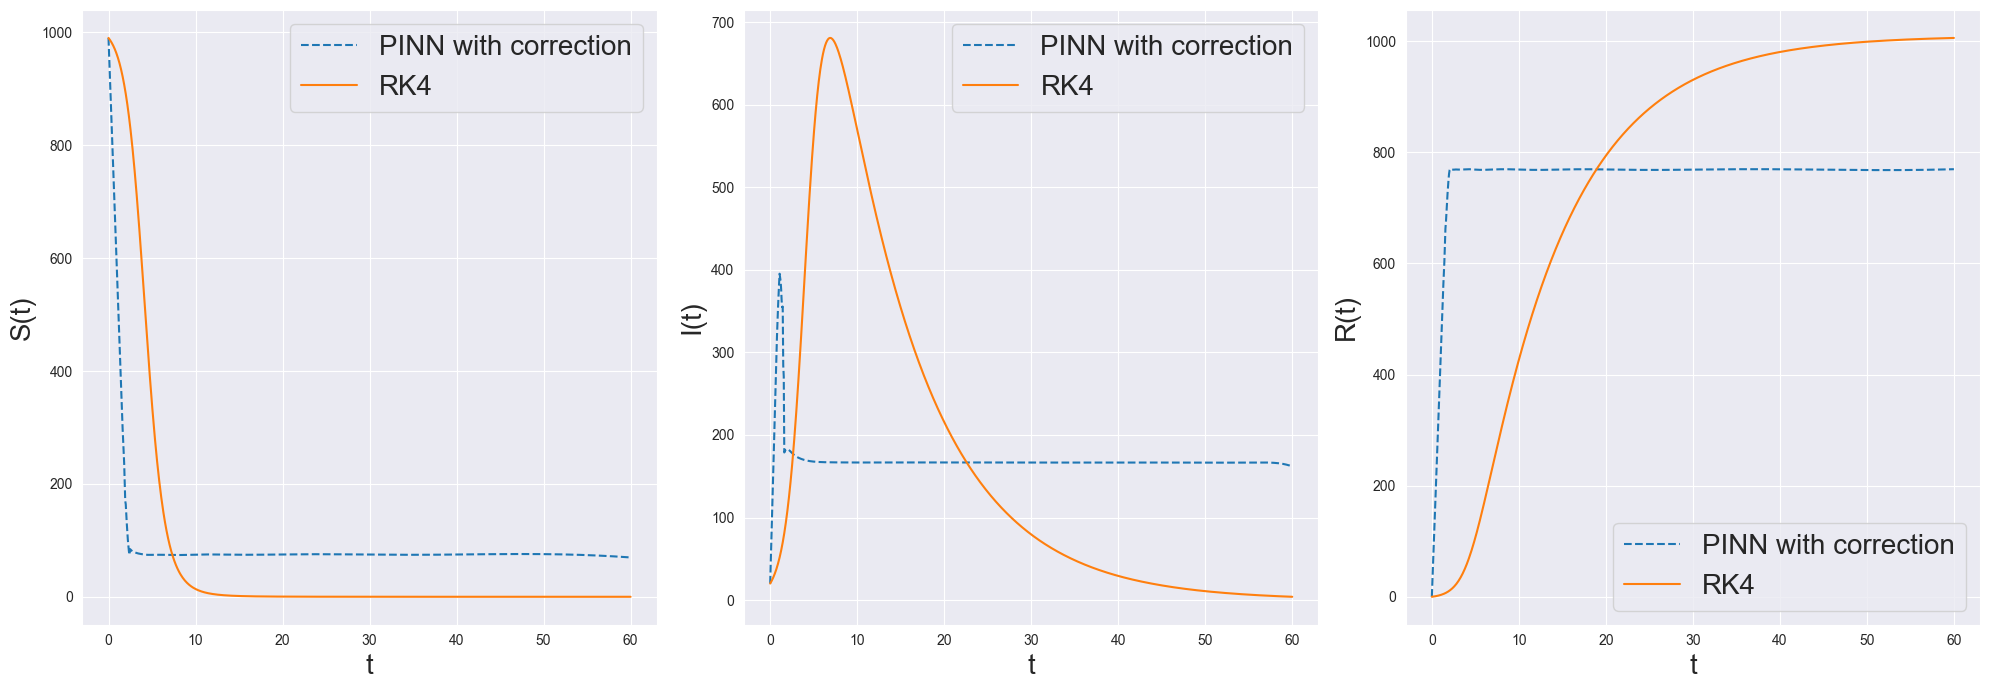

In [13]:
# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_pred1, label='PINN with correction', linestyle='--')
plt.plot(t_eval, y_eval[0], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('S(t)', fontsize=20)
#plt.title('Comparison of solutions of S trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.subplot(1, 3, 2)
plt.plot(x_test, u_pred2, label='PINN with correction', linestyle='--')
plt.plot(t_eval, y_eval[1], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('I(t)', fontsize=20)
#plt.title('Comparison of solutions of I trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.subplot(1, 3, 3)
plt.plot(x_test, u_pred3, label='PINN with correction', linestyle='--')
plt.plot(t_eval, y_eval[2], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('R(t)', fontsize=20)
#plt.title('Comparison of solutions of R trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('graphs/PINN_with_correction_SIR_solutions.pdf')

# for 60 days

In [7]:
# Define the loss function for the PINN
def pinn_loss(model1, model2, model3, x_collocation, ode_function, eq = '1'):
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)
    
    u_pred_collocation_1 = model1(x_collocation_tensor)
    u_pred_collocation_2 = model2(x_collocation_tensor)
    u_pred_collocation_3 = model3(x_collocation_tensor)
    
    if eq == '1':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_1, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_1), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_1 - torch.Tensor(y_eval_[0]))**2)
    elif eq == '2':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_2, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_2), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_2 - torch.Tensor(y_eval_[1]))**2)
    elif eq == '3':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_3, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_3), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_3 - torch.Tensor(y_eval_[2]))**2)
    else:
        return 
    
    # residual loss
    residual_loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
    
    total_loss = residual_loss_collocation + data_loss
    return total_loss

In [6]:
# training on [0,60] for 60 steps - each day

# RK4 
# Function defining the SIS model equations
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

t_span = (0, 60)  # Time span for integration
t_eval = np.linspace(t_span[0], t_span[1], 60)  # Time points for evaluation

# Initial conditions
y0 = [initial_S, initial_I, initial_R]

# Solve the ODEs
sol = solve_ivp(SIR_model, t_span, y0, args=(beta, gamma), dense_output=True)

y_eval_ = sol.sol(t_eval)

In [8]:
# Define the parameters
input_size = 1
hidden_size = 64
output_size = 1

initial_value_1 = initial_S
initial_value_2 = initial_I
initial_value_3 = initial_R

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 60
number_of_time_steps = 60

# Create instances of the PINN models
model1 = PINN(input_size, hidden_size, output_size, initial_value_1, initial_point_of_the_domain)
model2 = PINN(input_size, hidden_size, output_size, initial_value_2, initial_point_of_the_domain)
model3 = PINN(input_size, hidden_size, output_size, initial_value_3, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

# Define the optimizer for each model
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)

# Training loop for both models
# Early stopping parameters
best_loss = np.inf
patience = 100
epochs_no_improve = 0
num_epochs = 200000
early_stopping_epochs = 300

losses_ = []

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()

    loss1 = pinn_loss(model1, model2, model3, x_collocation, ode_function1, '1')
    loss2 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '2')
    loss3 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '3')

    total_loss = loss1 + loss2 + loss3
    
    losses_.append(total_loss)

    total_loss.backward()

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    
    # Early stopping check
    if epoch >= early_stopping_epochs:
        if total_loss < best_loss:
            best_loss = total_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break
                
                
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')



Epoch 1/200000, Loss: 1637101.7500
Epoch 101/200000, Loss: 1539657.7500
Epoch 201/200000, Loss: 1434827.5000
Epoch 301/200000, Loss: 1367957.0000
Epoch 401/200000, Loss: 1317867.6250
Epoch 501/200000, Loss: 1275116.0000
Epoch 601/200000, Loss: 1237000.8750
Epoch 701/200000, Loss: 1201791.2500
Epoch 801/200000, Loss: 1167532.3750
Epoch 901/200000, Loss: 1135138.6250
Epoch 1001/200000, Loss: 1105011.8750
Epoch 1101/200000, Loss: 1076734.3750
Epoch 1201/200000, Loss: 1049863.7500
Epoch 1301/200000, Loss: 1023605.5000
Epoch 1401/200000, Loss: 998332.1250
Epoch 1501/200000, Loss: 974400.5000
Epoch 1601/200000, Loss: 951344.7500
Epoch 1701/200000, Loss: 928841.7500
Epoch 1801/200000, Loss: 906744.8750
Epoch 1901/200000, Loss: 885022.3750
Epoch 2001/200000, Loss: 864568.1250
Epoch 2101/200000, Loss: 845583.3125
Epoch 2201/200000, Loss: 827779.8125
Epoch 2301/200000, Loss: 810995.8750
Epoch 2401/200000, Loss: 795131.6250
Epoch 2501/200000, Loss: 780116.0625
Epoch 2601/200000, Loss: 765891.6250

Epoch 21901/200000, Loss: 312416.5625
Epoch 22001/200000, Loss: 311662.5625
Epoch 22101/200000, Loss: 310816.1875
Epoch 22201/200000, Loss: 310036.8125
Epoch 22301/200000, Loss: 309262.9688
Epoch 22401/200000, Loss: 308500.7500
Epoch 22501/200000, Loss: 307750.3750
Epoch 22601/200000, Loss: 307064.6875
Epoch 22701/200000, Loss: 306279.5000
Epoch 22801/200000, Loss: 305535.8125
Epoch 22901/200000, Loss: 304817.8750
Epoch 23001/200000, Loss: 304112.2500
Epoch 23101/200000, Loss: 303418.3750
Epoch 23201/200000, Loss: 302793.1562
Epoch 23301/200000, Loss: 302062.4375
Epoch 23401/200000, Loss: 301408.5625
Epoch 23501/200000, Loss: 300750.7188
Epoch 23601/200000, Loss: 300098.6250
Epoch 23701/200000, Loss: 299459.8125
Epoch 23801/200000, Loss: 298830.2188
Epoch 23901/200000, Loss: 298236.3438
Epoch 24001/200000, Loss: 297626.5938
Epoch 24101/200000, Loss: 296989.4062
Epoch 24201/200000, Loss: 296394.0938
Epoch 24301/200000, Loss: 295802.7500
Epoch 24401/200000, Loss: 295220.8750
Epoch 24501/

Epoch 43501/200000, Loss: 246829.5312
Epoch 43601/200000, Loss: 246745.9688
Epoch 43701/200000, Loss: 246645.6875
Epoch 43801/200000, Loss: 246558.8750
Epoch 43901/200000, Loss: 246466.4375
Epoch 44001/200000, Loss: 246473.5156
Epoch 44101/200000, Loss: 246291.2188
Epoch 44201/200000, Loss: 246205.6250
Epoch 44301/200000, Loss: 246119.6562
Epoch 44401/200000, Loss: 246035.3281
Epoch 44501/200000, Loss: 246124.5000
Epoch 44601/200000, Loss: 245868.9375
Epoch 44701/200000, Loss: 245786.4375
Epoch 44801/200000, Loss: 245704.6250
Epoch 44901/200000, Loss: 245627.7500
Epoch 45001/200000, Loss: 245542.7344
Epoch 45101/200000, Loss: 245459.4375
Epoch 45201/200000, Loss: 245377.0938
Epoch 45301/200000, Loss: 245293.2812
Epoch 45401/200000, Loss: 245215.4531
Epoch 45501/200000, Loss: 245117.7500
Epoch 45601/200000, Loss: 245042.9688
Epoch 45701/200000, Loss: 244947.6250
Epoch 45801/200000, Loss: 244875.6875
Epoch 45901/200000, Loss: 244775.6250
Epoch 46001/200000, Loss: 244698.1562
Epoch 46101/

Epoch 65101/200000, Loss: 233884.8438
Epoch 65201/200000, Loss: 233858.5625
Epoch 65301/200000, Loss: 233834.7656
Epoch 65401/200000, Loss: 233839.2188
Epoch 65501/200000, Loss: 233853.2969
Epoch 65601/200000, Loss: 233759.9844
Epoch 65701/200000, Loss: 233753.5000
Epoch 65801/200000, Loss: 233738.5625
Epoch 65901/200000, Loss: 233686.2969
Epoch 66001/200000, Loss: 233659.2188
Epoch 66101/200000, Loss: 233657.9062
Epoch 66201/200000, Loss: 233620.3906
Epoch 66301/200000, Loss: 233587.9688
Epoch 66401/200000, Loss: 233577.4219
Epoch 66501/200000, Loss: 233542.4062
Epoch 66601/200000, Loss: 233523.8125
Epoch 66701/200000, Loss: 233495.8125
Epoch 66801/200000, Loss: 233480.2500
Epoch 66901/200000, Loss: 233465.2812
Epoch 67001/200000, Loss: 233429.7656
Epoch 67101/200000, Loss: 233411.3906
Epoch 67201/200000, Loss: 233448.6875
Epoch 67301/200000, Loss: 233365.6875
Epoch 67401/200000, Loss: 233344.8906
Epoch 67501/200000, Loss: 233324.2500
Epoch 67601/200000, Loss: 233304.9531
Epoch 67701/

Epoch 86701/200000, Loss: 229209.3125
Epoch 86801/200000, Loss: 229206.4688
Epoch 86901/200000, Loss: 229195.1250
Epoch 87001/200000, Loss: 229188.0938
Epoch 87101/200000, Loss: 229182.9062
Epoch 87201/200000, Loss: 229178.6875
Epoch 87301/200000, Loss: 229167.6250
Epoch 87401/200000, Loss: 229165.3438
Epoch 87501/200000, Loss: 229154.2969
Epoch 87601/200000, Loss: 229158.0000
Epoch 87701/200000, Loss: 229141.3438
Epoch 87801/200000, Loss: 229139.5781
Epoch 87901/200000, Loss: 229130.3281
Epoch 88001/200000, Loss: 229122.4688
Epoch 88101/200000, Loss: 229116.2188
Epoch 88201/200000, Loss: 229110.5781
Epoch 88301/200000, Loss: 229114.8750
Epoch 88401/200000, Loss: 229135.1250
Epoch 88501/200000, Loss: 229113.6875
Epoch 88601/200000, Loss: 229086.0938
Epoch 88701/200000, Loss: 229080.8750
Epoch 88801/200000, Loss: 229113.2500
Epoch 88901/200000, Loss: 229068.9062
Epoch 89001/200000, Loss: 229063.9844
Epoch 89101/200000, Loss: 229127.1250
Epoch 89201/200000, Loss: 229052.6094
Epoch 89301/

NameError: name 'u_pred_tensor1' is not defined

In [9]:
# Evaluate the trained models
with torch.no_grad():
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred_tensor1_ = model1(x_test_tensor)
    u_pred_tensor2_ = model2(x_test_tensor)
    u_pred_tensor3_ = model3(x_test_tensor)

    u_pred1_ = u_pred_tensor1_.numpy()
    u_pred2_ = u_pred_tensor2_.numpy()
    u_pred3_ = u_pred_tensor3_.numpy()

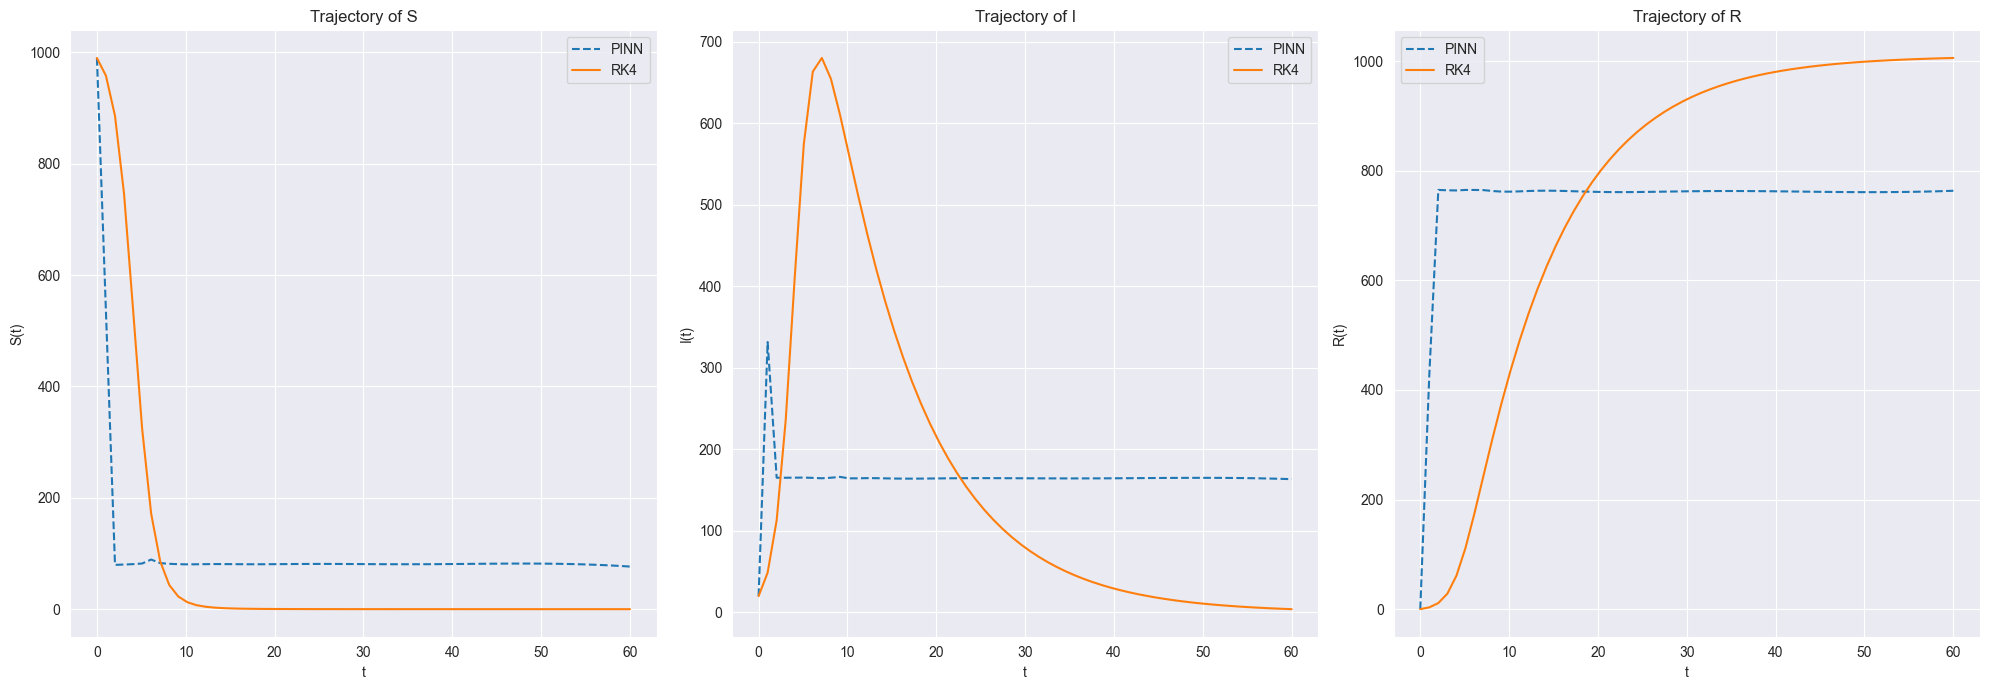

In [10]:
# Plot the results
plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_pred1_, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval_[0], label='RK4')
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Trajectory of S')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x_test, u_pred2_, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval_[1], label='RK4')
plt.xlabel('t')
plt.ylabel('I(t)')
plt.title('Trajectory of I')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x_test, u_pred3_, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval_[2], label='RK4')
plt.xlabel('t')
plt.ylabel('R(t)')
plt.title('Trajectory of R')
plt.legend()

plt.tight_layout()
plt.show()

# different set of parameters

In [5]:
# Parameters

initial_S = 990  # Initial number of susceptible individuals
initial_I = 20  # Initial number of infectious individuals
initial_R = 0 # Initial number of recovered individuals
N = initial_S + initial_I + initial_R # Total population size

beta = 0.25  # Rate of infection
gamma = 0.15  # Rate of recovery

In [6]:
# training on [0,60] for 1000 steps

# RK4 
# Function defining the SIS model equations
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

t_span = (0, 60)  # Time span for integration
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Initial conditions
y0 = [initial_S, initial_I, initial_R]

# Solve the ODEs
sol = solve_ivp(SIR_model, t_span, y0, args=(beta, gamma), dense_output=True)

y_eval__ = sol.sol(t_eval)

In [7]:
# Define the loss function for the PINN
def pinn_loss(model1, model2, model3, x_collocation, ode_function, eq = '1'):
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)
    
    u_pred_collocation_1 = model1(x_collocation_tensor)
    u_pred_collocation_2 = model2(x_collocation_tensor)
    u_pred_collocation_3 = model3(x_collocation_tensor)
    
    if eq == '1':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_1, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_1), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_1 - torch.Tensor(y_eval__[0]))**2)
    elif eq == '2':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_2, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_2), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_2 - torch.Tensor(y_eval__[1]))**2)
    elif eq == '3':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_3, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_3), 
                                                create_graph=True)[0]
        data_loss = torch.mean((u_pred_collocation_3 - torch.Tensor(y_eval__[2]))**2)
    else:
        return 
    
    # residual loss
    residual_loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
    
    total_loss = residual_loss_collocation + data_loss
    return total_loss

In [12]:
# Define the parameters
input_size = 1
hidden_size = 64
output_size = 1

initial_value_1 = initial_S
initial_value_2 = initial_I
initial_value_3 = initial_R

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 60
number_of_time_steps = 1000

# Create instances of the PINN models
model1 = PINN(input_size, hidden_size, output_size, initial_value_1, initial_point_of_the_domain)
model2 = PINN(input_size, hidden_size, output_size, initial_value_2, initial_point_of_the_domain)
model3 = PINN(input_size, hidden_size, output_size, initial_value_3, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

# Define the optimizer for each model
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)

# Training loop for both models
# Early stopping parameters
best_loss = np.inf
patience = 100
epochs_no_improve = 0
num_epochs = 200000
#early_stopping_epochs = 300

losses__ = []

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()

    loss1 = pinn_loss(model1, model2, model3, x_collocation, ode_function1, '1')
    loss2 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '2')
    loss3 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '3')

    total_loss = loss1 + loss2 + loss3
    
    losses__.append(total_loss)

    total_loss.backward()

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    
#     # Early stopping check
#     if epoch >= early_stopping_epochs:
#         if total_loss < best_loss:
#             best_loss = total_loss
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print("Early stopping")
#                 break
                
                
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')



Epoch 1/200000, Loss: 203807760.0000
Epoch 101/200000, Loss: 27444308.0000
Epoch 201/200000, Loss: 20163876.0000
Epoch 301/200000, Loss: 19928350.0000
Epoch 401/200000, Loss: 19670890.0000
Epoch 501/200000, Loss: 19424660.0000
Epoch 601/200000, Loss: 19201210.0000
Epoch 701/200000, Loss: 18994960.0000
Epoch 801/200000, Loss: 18789908.0000
Epoch 901/200000, Loss: 18573160.0000
Epoch 1001/200000, Loss: 18336780.0000
Epoch 1101/200000, Loss: 18005854.0000
Epoch 1201/200000, Loss: 17482202.0000
Epoch 1301/200000, Loss: 16693506.0000
Epoch 1401/200000, Loss: 15343968.0000
Epoch 1501/200000, Loss: 12961357.0000
Epoch 1601/200000, Loss: 9715006.0000
Epoch 1701/200000, Loss: 7915554.5000
Epoch 1801/200000, Loss: 7174622.0000
Epoch 1901/200000, Loss: 6702426.0000
Epoch 2001/200000, Loss: 6349187.0000
Epoch 2101/200000, Loss: 6064224.0000
Epoch 2201/200000, Loss: 5822048.0000
Epoch 2301/200000, Loss: 5611408.0000
Epoch 2401/200000, Loss: 5426280.0000
Epoch 2501/200000, Loss: 5261636.0000
Epoch 2

Epoch 21401/200000, Loss: 725221.0000
Epoch 21501/200000, Loss: 722629.6250
Epoch 21601/200000, Loss: 720995.1250
Epoch 21701/200000, Loss: 717597.2500
Epoch 21801/200000, Loss: 715133.8125
Epoch 21901/200000, Loss: 712899.0000
Epoch 22001/200000, Loss: 710325.0625
Epoch 22101/200000, Loss: 707959.6250
Epoch 22201/200000, Loss: 705645.7500
Epoch 22301/200000, Loss: 703345.5625
Epoch 22401/200000, Loss: 666507.8750
Epoch 22501/200000, Loss: 651404.0000
Epoch 22601/200000, Loss: 641579.5000
Epoch 22701/200000, Loss: 633417.3750
Epoch 22801/200000, Loss: 626431.1250
Epoch 22901/200000, Loss: 620215.5000
Epoch 23001/200000, Loss: 614134.8750
Epoch 23101/200000, Loss: 607942.7500
Epoch 23201/200000, Loss: 601895.1250
Epoch 23301/200000, Loss: 596651.7500
Epoch 23401/200000, Loss: 591599.1250
Epoch 23501/200000, Loss: 586629.8750
Epoch 23601/200000, Loss: 581446.3750
Epoch 23701/200000, Loss: 576540.7500
Epoch 23801/200000, Loss: 572026.1250
Epoch 23901/200000, Loss: 567823.8750
Epoch 24001/

Epoch 43001/200000, Loss: 326237.6875
Epoch 43101/200000, Loss: 325617.3125
Epoch 43201/200000, Loss: 326553.9375
Epoch 43301/200000, Loss: 324831.2188
Epoch 43401/200000, Loss: 324210.1250
Epoch 43501/200000, Loss: 324093.5000
Epoch 43601/200000, Loss: 323437.4688
Epoch 43701/200000, Loss: 385007.9688
Epoch 43801/200000, Loss: 322708.3125
Epoch 43901/200000, Loss: 322089.5938
Epoch 44001/200000, Loss: 330572.0625
Epoch 44101/200000, Loss: 321413.1250
Epoch 44201/200000, Loss: 320810.8438
Epoch 44301/200000, Loss: 321016.6250
Epoch 44401/200000, Loss: 320097.5000
Epoch 44501/200000, Loss: 319503.5000
Epoch 44601/200000, Loss: 319614.3125
Epoch 44701/200000, Loss: 318847.3125
Epoch 44801/200000, Loss: 318249.8750
Epoch 44901/200000, Loss: 320383.9688
Epoch 45001/200000, Loss: 317698.1875
Epoch 45101/200000, Loss: 317109.1250
Epoch 45201/200000, Loss: 325019.6562
Epoch 45301/200000, Loss: 316438.1875
Epoch 45401/200000, Loss: 315853.8750
Epoch 45501/200000, Loss: 320247.7500
Epoch 45601/

Epoch 64601/200000, Loss: 266783.7500
Epoch 64701/200000, Loss: 268554.0312
Epoch 64801/200000, Loss: 266648.6875
Epoch 64901/200000, Loss: 266230.5625
Epoch 65001/200000, Loss: 266842.9375
Epoch 65101/200000, Loss: 266188.6250
Epoch 65201/200000, Loss: 265767.8125
Epoch 65301/200000, Loss: 266220.4375
Epoch 65401/200000, Loss: 265638.5625
Epoch 65501/200000, Loss: 265224.0312
Epoch 65601/200000, Loss: 265898.3750
Epoch 65701/200000, Loss: 265340.9375
Epoch 65801/200000, Loss: 264913.2812
Epoch 65901/200000, Loss: 325833.6250
Epoch 66001/200000, Loss: 264967.3438
Epoch 66101/200000, Loss: 264525.7500
Epoch 66201/200000, Loss: 264131.8750
Epoch 66301/200000, Loss: 264626.8438
Epoch 66401/200000, Loss: 264146.3438
Epoch 66501/200000, Loss: 263734.4062
Epoch 66601/200000, Loss: 264139.5625
Epoch 66701/200000, Loss: 263646.8125
Epoch 66801/200000, Loss: 263246.3438
Epoch 66901/200000, Loss: 263608.0938
Epoch 67001/200000, Loss: 263143.9062
Epoch 67101/200000, Loss: 262868.2500
Epoch 67201/

Epoch 86201/200000, Loss: 241476.5000
Epoch 86301/200000, Loss: 242090.3750
Epoch 86401/200000, Loss: 241465.9375
Epoch 86501/200000, Loss: 247334.6250
Epoch 86601/200000, Loss: 241561.9688
Epoch 86701/200000, Loss: 241061.8438
Epoch 86801/200000, Loss: 241663.2344
Epoch 86901/200000, Loss: 241007.7500
Epoch 87001/200000, Loss: 245699.1406
Epoch 87101/200000, Loss: 241020.6875
Epoch 87201/200000, Loss: 240547.5156
Epoch 87301/200000, Loss: 241072.8438
Epoch 87401/200000, Loss: 240501.9844
Epoch 87501/200000, Loss: 241174.0938
Epoch 87601/200000, Loss: 240385.8594
Epoch 87701/200000, Loss: 247707.4062
Epoch 87801/200000, Loss: 240425.7812
Epoch 87901/200000, Loss: 239939.1875
Epoch 88001/200000, Loss: 240454.5938
Epoch 88101/200000, Loss: 239874.2344
Epoch 88201/200000, Loss: 241098.8750
Epoch 88301/200000, Loss: 239792.7812
Epoch 88401/200000, Loss: 242579.2188
Epoch 88501/200000, Loss: 239851.2969
Epoch 88601/200000, Loss: 239355.9688
Epoch 88701/200000, Loss: 239853.3125
Epoch 88801/

Epoch 107601/200000, Loss: 251694.7969
Epoch 107701/200000, Loss: 226116.7188
Epoch 107801/200000, Loss: 227397.5312
Epoch 107901/200000, Loss: 225836.3438
Epoch 108001/200000, Loss: 226418.0000
Epoch 108101/200000, Loss: 225671.0625
Epoch 108201/200000, Loss: 226208.7031
Epoch 108301/200000, Loss: 225533.4688
Epoch 108401/200000, Loss: 226139.2656
Epoch 108501/200000, Loss: 225453.4219
Epoch 108601/200000, Loss: 226087.0938
Epoch 108701/200000, Loss: 225363.8125
Epoch 108801/200000, Loss: 226738.4688
Epoch 108901/200000, Loss: 225450.7812
Epoch 109001/200000, Loss: 232253.1562
Epoch 109101/200000, Loss: 225537.5312
Epoch 109201/200000, Loss: 225027.5469
Epoch 109301/200000, Loss: 225482.6875
Epoch 109401/200000, Loss: 224930.4688
Epoch 109501/200000, Loss: 225351.8906
Epoch 109601/200000, Loss: 224808.8281
Epoch 109701/200000, Loss: 225126.3750
Epoch 109801/200000, Loss: 255333.4062
Epoch 109901/200000, Loss: 224974.7344
Epoch 110001/200000, Loss: 314989.3125
Epoch 110101/200000, Loss

Epoch 128701/200000, Loss: 221935.5000
Epoch 128801/200000, Loss: 216328.2500
Epoch 128901/200000, Loss: 220349.3438
Epoch 129001/200000, Loss: 216237.0625
Epoch 129101/200000, Loss: 220176.6875
Epoch 129201/200000, Loss: 216193.6719
Epoch 129301/200000, Loss: 218541.6250
Epoch 129401/200000, Loss: 216085.7812
Epoch 129501/200000, Loss: 217066.4688
Epoch 129601/200000, Loss: 215992.3438
Epoch 129701/200000, Loss: 216981.5156
Epoch 129801/200000, Loss: 215931.6875
Epoch 129901/200000, Loss: 223398.4531
Epoch 130001/200000, Loss: 216148.1719
Epoch 130101/200000, Loss: 215795.9531
Epoch 130201/200000, Loss: 217938.4062
Epoch 130301/200000, Loss: 215943.9062
Epoch 130401/200000, Loss: 215646.0312
Epoch 130501/200000, Loss: 216056.6562
Epoch 130601/200000, Loss: 215652.7031
Epoch 130701/200000, Loss: 216402.7500
Epoch 130801/200000, Loss: 215639.0938
Epoch 130901/200000, Loss: 218302.5312
Epoch 131001/200000, Loss: 215562.6250
Epoch 131101/200000, Loss: 216303.6250
Epoch 131201/200000, Loss

Epoch 149801/200000, Loss: 209644.1562
Epoch 149901/200000, Loss: 210092.7031
Epoch 150001/200000, Loss: 209677.8594
Epoch 150101/200000, Loss: 305520.1250
Epoch 150201/200000, Loss: 210035.3750
Epoch 150301/200000, Loss: 209639.5938
Epoch 150401/200000, Loss: 209436.5312
Epoch 150501/200000, Loss: 209840.1562
Epoch 150601/200000, Loss: 209482.7812
Epoch 150701/200000, Loss: 213947.1875
Epoch 150801/200000, Loss: 209609.2812
Epoch 150901/200000, Loss: 209320.1875
Epoch 151001/200000, Loss: 211433.1250
Epoch 151101/200000, Loss: 209540.4844
Epoch 151201/200000, Loss: 209253.2812
Epoch 151301/200000, Loss: 210479.8750
Epoch 151401/200000, Loss: 209336.3750
Epoch 151501/200000, Loss: 209082.6562
Epoch 151601/200000, Loss: 209389.2969
Epoch 151701/200000, Loss: 209069.2188
Epoch 151801/200000, Loss: 210017.3125
Epoch 151901/200000, Loss: 209141.4375
Epoch 152001/200000, Loss: 211017.1250
Epoch 152101/200000, Loss: 209259.0938
Epoch 152201/200000, Loss: 208931.3125
Epoch 152301/200000, Loss

Epoch 170901/200000, Loss: 204193.2812
Epoch 171001/200000, Loss: 209730.8750
Epoch 171101/200000, Loss: 204639.4688
Epoch 171201/200000, Loss: 204212.1562
Epoch 171301/200000, Loss: 213837.0000
Epoch 171401/200000, Loss: 204267.7812
Epoch 171501/200000, Loss: 203956.3281
Epoch 171601/200000, Loss: 204598.4531
Epoch 171701/200000, Loss: 204060.4219
Epoch 171801/200000, Loss: 220754.0156
Epoch 171901/200000, Loss: 204126.1719
Epoch 172001/200000, Loss: 203819.6562
Epoch 172101/200000, Loss: 204638.3750
Epoch 172201/200000, Loss: 204042.7500
Epoch 172301/200000, Loss: 203757.9531
Epoch 172401/200000, Loss: 204275.7031
Epoch 172501/200000, Loss: 203841.1406
Epoch 172601/200000, Loss: 207149.1250
Epoch 172701/200000, Loss: 204003.8281
Epoch 172801/200000, Loss: 203683.8906
Epoch 172901/200000, Loss: 204309.5625
Epoch 173001/200000, Loss: 203750.9219
Epoch 173101/200000, Loss: 209542.5625
Epoch 173201/200000, Loss: 203804.0938
Epoch 173301/200000, Loss: 203510.8750
Epoch 173401/200000, Loss

Epoch 192001/200000, Loss: 200218.5469
Epoch 192101/200000, Loss: 203405.9375
Epoch 192201/200000, Loss: 200492.5938
Epoch 192301/200000, Loss: 200153.2656
Epoch 192401/200000, Loss: 201922.2656
Epoch 192501/200000, Loss: 200264.1250
Epoch 192601/200000, Loss: 199983.6562
Epoch 192701/200000, Loss: 200363.1719
Epoch 192801/200000, Loss: 200012.4219
Epoch 192901/200000, Loss: 201164.9688
Epoch 193001/200000, Loss: 200163.2812
Epoch 193101/200000, Loss: 199888.8594
Epoch 193201/200000, Loss: 200218.2812
Epoch 193301/200000, Loss: 199883.8438
Epoch 193401/200000, Loss: 200399.5938
Epoch 193501/200000, Loss: 199935.4844
Epoch 193601/200000, Loss: 202355.1562
Epoch 193701/200000, Loss: 200128.0312
Epoch 193801/200000, Loss: 199806.7812
Epoch 193901/200000, Loss: 201395.7500
Epoch 194001/200000, Loss: 200203.2969
Epoch 194101/200000, Loss: 199856.7812
Epoch 194201/200000, Loss: 203297.8438
Epoch 194301/200000, Loss: 199939.6562
Epoch 194401/200000, Loss: 199663.9531
Epoch 194501/200000, Loss

In [13]:
# Evaluate the trained models
with torch.no_grad():
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred_tensor1__ = model1(x_test_tensor)
    u_pred_tensor2__ = model2(x_test_tensor)
    u_pred_tensor3__ = model3(x_test_tensor)

    u_pred1__ = u_pred_tensor1__.numpy()
    u_pred2__ = u_pred_tensor2__.numpy()
    u_pred3__ = u_pred_tensor3__.numpy()

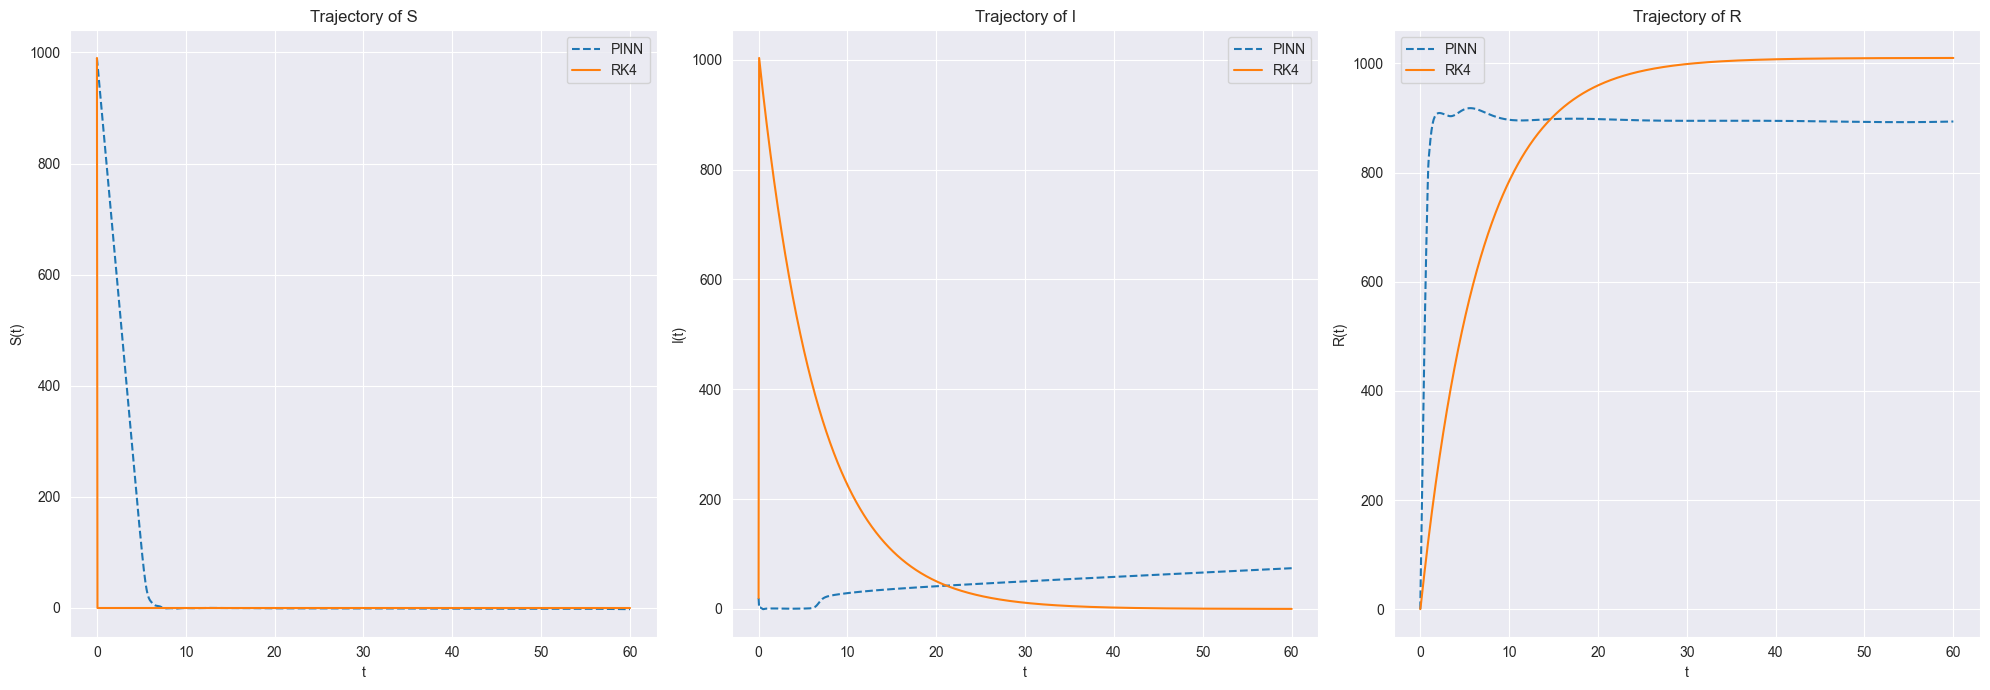

In [16]:
# Plot the results
plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_pred1__, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval__[0], label='RK4')
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Trajectory of S')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x_test, u_pred2__, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval__[1], label='RK4')
plt.xlabel('t')
plt.ylabel('I(t)')
plt.title('Trajectory of I')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x_test, u_pred3__, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval__[2], label='RK4')
plt.xlabel('t')
plt.ylabel('R(t)')
plt.title('Trajectory of R')
plt.legend()

plt.tight_layout()
plt.show()